
# Cliffs and Higher-Order Instability

Cliff in the loss function surface implies that a small change in some of the weights can either change the loss in a tiny way or suddenly change the loss by such a large amount that the resulting solution is even futher away from the true optimum. 

<font color='red'>Cliffs are caused by sharing the parameters in all temporal layers, which is a general structure of RNN (recurrent neural network).</font> In RNN, the layers with the shared weights are cascaded, which means the shared weights of different layers are multiplied during neural network prediction, thus a small change in a parameter can either blow up or have negligible effect on the value of the loss function. Furthermore, its hard to control the step size in a way that prevents one of these two events. This is the typical behavior one would encounter near a cliff. As a result, its easy to miss the optimum during a gradient-descent step.

Such problem are often addressed with techniques that clip the gradient.





------------------

# Gradient Clippging

## Value-based clipping

In value-based clipping, a minimum and maximum threshold are set on the gradient values. All partial derivatives that are less than the minumum are set to the minimum threshold. All partial derivatives that are greater than the maximun are set to the maximum threshold. However, such algorithm changes the overall direction of the gradient, which may leads to poor learning result.

## Norm-based clipping

In this case, the entire gradient vector is normalized by the $L_2$-norm of the entire vector. Note that this type of clipping does not change the relative magnitudes of the updates along different directions. However, in this algorithm, the mode (length) of the gradient is fixed, which leads to oscilattion when the weights reaching to the optimal point.


The clipping methods are done only on the basis of the current values of the gradients rather than their historical values, which also limits the effects of gradient clipping compared to many other methods. However, it is particularly effective in avoiding the exploding gradient problem in RNN.



<IPython.core.display.Javascript object>


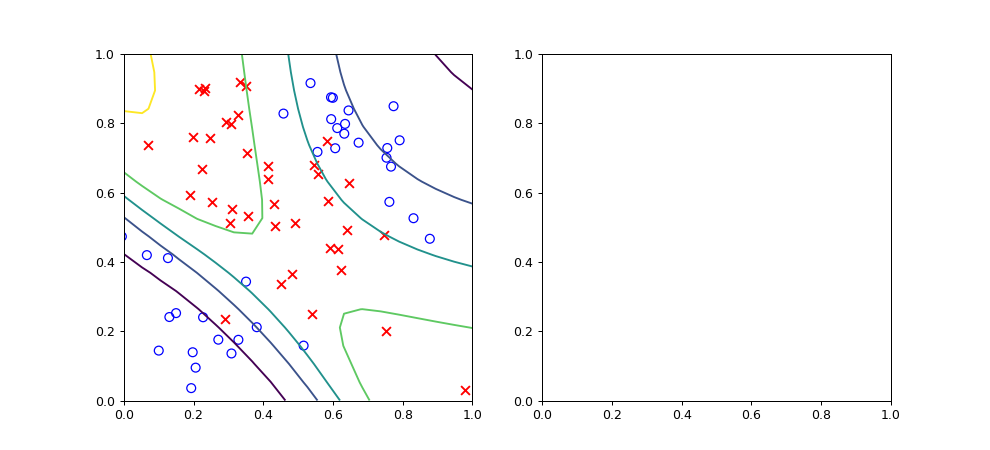

In [39]:

# for showing iteratively
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import warnings

# convert warnings to error
warnings.filterwarnings("error")

# learning rate decay
epoch_t = 0

# conjugate gradient algorithm
q0 = None


TRAIN_FINISHED = 100000

LT = 5000
LR = 0.1
X = None
Y = None
x = None
y = None
cont = None
levels = None

Gaussian = lambda t, mu, sigma: 1.0/(sigma*np.sqrt(2*np.pi))*np.exp(-(t-mu)**2/(2*sigma**2))

class EXP_TRAIN_FINISHED(Exception):
    pass

def gradient_clipping(derivatives):
    Gmax = 0.01
    Gmin = -0.01
    G = np.clip(derivatives, Gmin, Gmax)
    return -G

def gradient_clipping_norm(derivatives):
    a = 0.5
    G = a*derivatives/np.sqrt(np.sum(derivatives**2))
    return -G

def tanh(a):
    y = np.tanh(a)
    return y

def dtanh(o):
    y = 1-o**2
    return y

def sigmoid(a):
    y = 1.0/(1.0+np.exp(-a))
    return y

def dsigmoid(o):
    y = o*(1-o)
    return y

def compute_weights_error(derivatives, variance):
    ret = LR * variance * derivatives
    return ret

class Layer:
    network = None
    unit_number = 0
    outputs = None
    errors = None
    weights = None
    derivatives = None
    prev_layer = None
    next_layer = None
    variance = 0.0
#     bias = None
#     bias_derivatives = None
    
    w_start = 0
    b_start = 0
    act_errors = None
    
    act_func = tanh
    link_func = dtanh
    
    def __init__(self, K, afunc=tanh, lfunc=dtanh):
        self.unit_number = K
        self.outputs = np.zeros(K)
        self.errors = np.zeros(K)
        self.act_errors = np.zeros(K)
#         self.bias = np.zeros(K)
#         self.bias_derivatives = np.zeros(K)
        self.act_func = afunc
        self.link_func = lfunc
        
    def build_connection(self, network):
        self.network = network
        j = self.prev_layer.unit_number
        self.variance = 1.0/(j * self.unit_number)
#         self.weights = np.random.normal(0,\
#                                         np.sqrt(self.variance),\
#                                         (self.unit_number, j))
#         self.derivatives = np.zeros((self.unit_number, j))
        
        w_size = self.unit_number * j
        self.w_start = self.network.w_size
        self.network.weights = np.hstack((self.network.weights, np.random.normal(0, np.sqrt(self.variance), w_size)))
        self.network.w_size += w_size
        
        b_size = self.unit_number
        self.b_start = self.network.w_size
        self.network.weights = np.hstack((self.network.weights, np.zeros(b_size)))
        self.network.w_size += b_size
        
        self.network.derivatives = np.zeros(self.network.w_size)
        self.network.hessian = np.zeros((self.network.w_size, self.network.w_size))
        self.network.b = np.zeros(self.network.w_size)
    
#     def forward_propagation(self):
#         for k in range(self.unit_number):
#             self.outputs[k] = self.act_func(np.sum(self.prev_layer.outputs * self.weights[k])+self.bias[k])

    def forward_propagation(self):
        for k in range(self.unit_number):
            s = 0.0
            for j in range(self.prev_layer.unit_number):
                s += self.prev_layer.outputs[j] * self.network.weights[self.w_start+k*self.prev_layer.unit_number+j]
            s += self.network.weights[self.b_start + k]
            self.outputs[k] = self.act_func(s)
            
#     def backward_propagation(self, update_weight):
#         for k in range(self.unit_number):
#             self.errors[k] = self.link_func(self.outputs[k]) * np.sum(self.next_layer.weights[:,k] * self.next_layer.errors)
#             self.derivatives[k] += self.errors[k] * self.prev_layer.outputs
#         self.bias_derivatives += self.errors
#         if update_weight == 1:
#             self.weights -= compute_weights_error(self.derivatives, self.variance)
#             self.derivatives *= 0.0
#             self.bias -= compute_weights_error(self.bias_derivatives, self.variance)
#             self.bias_derivatives *= 0.0

    def backward_propagation(self, update_weight):
        for k in range(self.unit_number):
            s = 0.0
            a = 0.0
            for l in range(self.next_layer.unit_number):
                s += self.next_layer.errors[l] * self.network.weights[self.next_layer.w_start+l*self.unit_number+k]
                a += self.next_layer.act_errors[l] * self.network.weights[self.next_layer.w_start+l*self.unit_number+k]
            self.errors[k] = self.link_func(self.outputs[k]) * s
            self.act_errors[k] = self.link_func(self.outputs[k]) * a
            for j in range(self.prev_layer.unit_number):
                self.network.derivatives[self.w_start+k*self.prev_layer.unit_number+j] += self.errors[k] * self.prev_layer.outputs[j]
                self.network.b[self.w_start+k*self.prev_layer.unit_number+j] = self.act_errors[k] * self.prev_layer.outputs[j]
            self.network.derivatives[self.b_start+k] += self.errors[k]
            self.network.b[self.b_start+k] = self.act_errors[k]
            
    def dump(self):
        print("outputs {}".format(self.outputs))
        print("errors {}".format(self.errors))
        print("weights {}".format(self.weights))
        print("derivatives {}".format(self.derivatives))

# Mixture Gaussian Parameters Layer
class OutputLayer(Layer):
    targets = None
#     def backward_propagation(self, update_weight):
#         self.errors = self.outputs-self.targets
#         for k in range(self.unit_number):
#             self.derivatives[k] += self.errors[k] * self.prev_layer.outputs
#         self.bias_derivatives += self.errors
#         if update_weight == 1:
#             self.weights -= compute_weights_error(self.derivatives, self.variance)
#             self.derivatives *= 0.0
#             self.bias -= compute_weights_error(self.bias_derivatives, self.variance)
#             self.bias_derivatives *= 0.0
            
    def backward_propagation(self, update_weight):
        self.errors = self.outputs-self.targets
        self.act_errors = np.ones(self.act_errors.shape)
        for k in range(self.unit_number):
            for j in range(self.prev_layer.unit_number):
                self.network.derivatives[self.w_start+k*self.prev_layer.unit_number+j] += self.errors[k] * self.prev_layer.outputs[j]
                self.network.b[self.w_start+k*self.prev_layer.unit_number+j] = self.act_errors[k] * self.prev_layer.outputs[j]
            self.network.derivatives[self.b_start+k] += self.errors[k]
            self.network.b[self.b_start+k] = self.act_errors[k]
            
    def update_target(self, t):
        self.targets = t

class InputLayer(Layer):
    outputs = None
    unit_number = 0
    prev_layer = None
    next_layer = None
    
    def __init__(self, K):
        self.unit_number = K
        
    def build_connection(self, network):
        self.network = network
        return
        
    def update_input(self, inputs):
        self.outputs = inputs

class Network:
    input_layer = None
    output_layer = None
    inputs = None
    targets = None
    hessian = None
    weights = None
    derivatives = None
    b = None
    w_size = 0
    
    def __init__(self):
        self.weights = np.array([])
        return
    
    def add_layer(self, layer):
        if self.input_layer == None:
            self.input_layer = layer
        else:
            layer.prev_layer = self.output_layer
            self.output_layer.next_layer = layer
            
        self.output_layer = layer
        layer.build_connection(self)
        
    def update_hessian(self):
        b = self.b.reshape(-1, 1)
        y = self.output_layer.outputs[0]
        self.hessian += y * (1-y) * (b @ b.T)
        
    def update(self, update_weight):
        self.update_hessian()
        if update_weight == 1:
            if np.allclose(self.derivatives, np.zeros(self.w_size)):
                raise EXP_TRAIN_FINISHED("Train finished")
            #print(self.weights)
            #print(self.derivatives)
            #print(self.hessian)
            #print(np.linalg.inv(self.hessian))
            
            # Value-based clipping algorithm
            ret = gradient_clipping(self.derivatives)
            
            # Norm-based clipping algorithm
            #ret = gradient_clipping_norm(self.derivatives)
            
            self.weights += ret
            self.derivatives *= 0
            self.hessian *= 0
        return 1
        
    def train(self, observations, targets):
        N = len(observations)
        for n in range(N):
            self.input_layer.update_input(observations[n])
            self.output_layer.update_target(targets[n])
            
            layer = self.input_layer.next_layer
            while layer != None:
                layer.forward_propagation()
                layer = layer.next_layer
            
            # gradient descent/stotastic gradient descent
            if n == N-1:
                update_weight = 1
            else:
                update_weight = 0
            layer = self.output_layer
            while layer != self.input_layer:
                layer.backward_propagation(update_weight)
                layer = layer.prev_layer
            self.update(update_weight)

    def Get_Error(self, observations, targets, show):
        N = len(observations)
        es = 0.0
        for n in range(N):
            self.inputs = observations[n]
            self.targets = targets[n]
            
            layer = self.input_layer
            while layer != None:
                layer.forward_propagation()
                layer = layer.next_layer
            #print("target {}".format(self.targets))
            #print("output {}".format(self.output_layer.outputs))
            #e = np.sum(self.targets * np.log(self.output_layer.outputs))
            # for sigmoid only
            e = self.targets[0] * np.log(self.output_layer.outputs[0]) \
                + (1 - self.targets[0]) * np.log(1 - self.output_layer.outputs[0])
            es += e
            if show == 1:
                print(self.targets, self.output_layer.outputs)
        return -es
                
    def test(self, new_input):
        self.input_layer.update_input(new_input)
        
        layer = self.input_layer.next_layer
        while layer != None:
            layer.forward_propagation()
            layer = layer.next_layer
        return self.output_layer.outputs
    
    def dump(self):
        layer = self.input_layer.next_layer
        while layer != None:
            layer.dump()
            layer = layer.next_layer
        return

def gen_training_data(ax):
    mean1 = [0.2, 0.2]
    cov1 = [[0.03, -0.01], 
           [-0.01, 0.02]]
    X1 = np.random.multivariate_normal(mean1, cov1, 20)

    mean12 = [0.7, 0.7]
    cov12 = [[0.01, -0.01], 
           [-0.01, 0.02]]
    X12 = np.random.multivariate_normal(mean12, cov12, 20)
    X1 = np.vstack((X1, X12))
    T1 = np.zeros(len(X1))
    
    mean2 = [0.4, 0.6]
    cov2 = [[0.03, -0.02], 
           [-0.02, 0.04]]
    X2 = np.random.multivariate_normal(mean2, cov2, 40)
    T2 = np.ones(len(X2))
    
    ax.scatter(X1.T[0], X1.T[1], s=50,  facecolors='none', edgecolors='blue')
    ax.scatter(X2.T[0], X2.T[1], s=50,  facecolors='red', edgecolors='none', marker='x')
    
    X = np.vstack((X1, X2))
    T = np.hstack((T1, T2))
    return X, T

def show_pic(network, ax, fig, init=0):
    global x, y, X, Y, Z, cont, levels
    if init == 1:
        x = np.linspace(0,1,20)
        y = np.linspace(0,1,20)
        X, Y = np.meshgrid(x, y)
        levels = np.arange(0.1, 1.1, 0.2)
    
    Z = np.zeros(X.shape)
    for i in range(len(y)):
        for j in range(len(x)):
            Z[i][j] = network.test([x[j], y[i]])
    if init != 1:
        for coll in cont.collections: 
            coll.remove()
    cont = ax.contour(X, Y, Z, levels=levels) 
    fig.canvas.draw()
    
def training_show_process(network, X, T, fig, ax):
    show_pic(network, ax, fig, 1)

    for i in range(LT):
        network.train(X, T)
        if i % 10 == 9:
            show_pic(network, ax, fig)
    return

def build_network():
    network = Network()
    ilayer = InputLayer(2)
    network.add_layer(ilayer)
    layer1 = Layer(10)
    network.add_layer(layer1)
    # layer2 = Layer(5)
    # network.add_layer(layer2)
    olayer = OutputLayer(1, sigmoid, dsigmoid)
    network.add_layer(olayer)
    return network

def main():
    fig = plt.figure(figsize=(11,5), dpi=60)
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    X, T = gen_training_data(ax1)
    network = build_network()
    try:
        training_show_process(network, X, T, fig, ax1)
    except EXP_TRAIN_FINISHED:
        show_pic(network, ax1, fig)
        raise

if __name__=="__main__":
    main()